### Sentiment Analysis - TripAdvisor Reviews

### Objective: ###
#### The objective of the current analysis is to use Deep Learning - RNN and LSTM Models to evaluate the sentiments in the hotel reviews of Tripadvisor as either 'positive' or 'negative' #### 

### Context : 
#### Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged. With this dataset, consisting of 20k reviews crawled from Tripadvisor, one can explore what makes a great hotel and maybe even use this model in one's travels! ####
This dataset contains 20491 reviews of different Hotel stays extracted from Tripadvisor portal. Reviews are rated from '1' till '5', with 5 being the most positive rating. For the ease of analysis, ratings __'1' and '2' would be considered as negative and '5' as positive and the ratings '3' and '4' won't be considered for the analysis__. 

#### Citation: Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223. https://zenodo.org/record/1219899#.YLSig6gzZPY ####

### Importing the necessary libraries

In [1]:
import numpy as np, os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import math

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.linear_model import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Reading the data

In [4]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


#### Let's check out randomly Review number 10

In [5]:
print('Rating : {}.\nReview : {}'.format(data['Rating'][10],data['Review'][10]))

Rating : 2.
Review : poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,  


> This shows a rating of '2' or a negative sentiment

In [6]:
data.shape

(20491, 2)

In [7]:
data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

### Data Preprocessing

Since the Dataset is pretty huge with 20491 reviews, for the analysis I will take a smaller sample with only 5000 reviews.   
Rating __'5'__ will be considered as __positive__ and ratings __'1' & '2'__ would be considered as __negative__ reviews.   
So firstly, the rows with ratings '4' and '5' will be removed.

In [8]:
dataxy = data[(data.Rating==1) | (data.Rating==2) | (data.Rating==5)]

In [9]:
dataxy['Rating'].value_counts()

5    9054
2    1793
1    1421
Name: Rating, dtype: int64

Now out of these observations, a random selection of 5000 reviews would be done for the analysis. It would be ensured that the resulting smaller sample is not highly imbalanced (i.e ratio of ratings '1' + '2' combined to rating '5' should not be less than 1:10).    

For this, the __random integer generator__ from Numpy would be used.

In [10]:
dataxy.reset_index(drop=True,inplace=True)
dataxy.head()

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,"unique, great stay, wonderful time hotel monac...",5
2,"great stay great stay, went seahawk game aweso...",5
3,love monaco staff husband stayed hotel crazy w...,5
4,"cozy stay rainy city, husband spent 7 nights m...",5


In [11]:
# Function to randomly select 5000 reviews from the smaller Dataframe
def rand_splitdf(dataframe):
    obs = dataframe.shape[0] # number of rows in the DF
    rng = np.random.default_rng(seed=42)  # random number generator object
    rints = rng.integers(low=0, high=obs, size=5000) # generating 5000 random indexes between 0 and highest row in the DF
    print('The random indexes generated are {}'.format(rints))
    dataf = dataframe.iloc[rints]   # create a DF based on the random indexes 
    print('The distribution of ratings after compressing the DF : \n{}'.format(dataf['Rating'].value_counts()))
    return dataf    

In [12]:
dataf = rand_splitdf(dataxy)

The random indexes generated are [ 1094  9494  8030 ... 10053  8324  6116]
The distribution of ratings after compressing the DF : 
5    3657
2     730
1     613
Name: Rating, dtype: int64


In [13]:
dataf.shape

(5000, 2)

Renaming the positive ratings as '1' and negative as '0'

In [14]:
dataf.loc[:,'Rating'] = [1 if x>4 else 0 for x in dataf.loc[:,'Rating']]
dataf['Rating'].value_counts()

C:\Users\ashis\Installed\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1    3657
0    1343
Name: Rating, dtype: int64

### Recurrent Neural Networks

Here the text in the reviews would be filtered for special characters, numbers etc. and the words would be converted to smaller case for ease of use

In [15]:
x,y = (dataf['Review'].values, dataf['Rating'].values)

In [16]:
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
maxlen = 150  # maximum input length of a text sequence - truncate after this
batch_size = 32

#### Tokenizer:
Tokenizer would embed the individual words into integer arrays. Padding would ensure that the length of the arrays stays upto a max. length of maxlen. Longer arrays would be truncated and shorter ones would be padded with zeros '0'. 

In [17]:
tk = Tokenizer(lower = True, filters = filters)
tk.fit_on_texts(x)
x_seq = tk.texts_to_sequences(x)
x_pad = pad_sequences(x_seq, maxlen=maxlen, padding='post')

In [18]:
print("Review 5 : \n{}\n".format(x[5]))
print("Review 5 after Mapping: \n{}".format(x_pad[5]))

Review 5 : 
loved loved loved, stayed hotel 17 20 march loved minute, definately nicest hotel stayed, lobby/reception/bar area gorgeous, roof deck fantastic chill area bit windy try roof pool, did spend couple hours basement spa pool wonderful, booked classic room listed having inner atrium courtyard view shown room 606 6th floor actually outside view overlooking private terraces rooms, n't bad view means expecting inside room outside view able sun bonus.the room lovely clean king size bed minibar prices reasonable kettle bathrobe slippers, pre-ordered bottle cava brought room delivered 5 mins shown room, did minutes work shower worked day realised aircon control cupboard, room stiffling hot thought aircon not working, called recepton door 2 minutes work aircon unit.the breakfast divine chose n't able justify paying 18 euros thankfully incuded rate paid room.our real critisism cost drinks bar, yes expect expensive 25 euros 2 glasses sangria bit steep did n't order drinks bar, distict l

### Stratified Shuffle Split
Here 25% of the data would be split into the test set and rest for training.

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_index, test_index = next(sss.split(x_pad, y))
x_train, x_test = x_pad[train_index], x_pad[test_index]
y_train, y_test = y[train_index], y[test_index]
print('Shape of x_train is : {}'.format(x_train.shape))
print('Shape of y_test is : {}'.format(y_test.shape))

Shape of x_train is : (3750, 150)
Shape of y_test is : (1250,)


### User-defined functions

In [20]:
scores_ = pd.DataFrame(columns=['Model','Precision','Recall','ROC-AUC score']) # store the scores of each model
row = 0
models_ = [] # store models
target_names = ['negative','positive']

In [21]:
# Function to calculate the metrics
def calc_scores(name,model):
    global row
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    y_prob = (model.predict_proba(x_test))
    print(name,':\n')
    print(classification_report(y_test, y_pred))
    precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')
    roc_ = roc_auc_score(y_test, y_prob,average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    print('Precision : {:.3f}'.format(precision))
    print('Recall : {:.3f}'.format(recall))
    print('ROC-AUC score : {:.3f}'.format(roc_))
    print('Accuracy : {:.3f}'.format(accuracy))
    scores_.loc[row,'Model'] = name
    scores_.loc[row,'Precision'] = round(precision,4)
    scores_.loc[row,'Recall'] = round(recall,4)
    scores_.loc[row,'ROC-AUC score'] = round(roc_,4)
    scores_.loc[row,'Accuracy'] = round(accuracy,4)
    row+= 1
    models_.append({name:model})
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,annot=True, fmt='d');

### Model 1 : Simple RNN
First Model would be a simple RNN with 5 Hidden Layers. Vocabulary size would be the default words stored in the Tokenizer object of Keras.     
Embedding size = maxlen.

In [22]:
rnn_hidden_dim = 5
vocab_size = len(tk.word_counts.keys())+1
model_rnn1 = Sequential()
model_rnn1.add(Embedding(vocab_size,maxlen)) #This layer takes each integer in the sequence and embeds it in a 150-dimensional vector
model_rnn1.add(SimpleRNN(rnn_hidden_dim,
                       kernel_initializer=initializers.RandomNormal(stddev = 0.001),
                        recurrent_initializer=initializers.Identity(gain = 1.0),
                       activation='relu',
                       input_shape= x_train.shape[1:]))

model_rnn1.add(Dense(1, activation='sigmoid'))

In [23]:
# Number of default features in Tokenizer in Keras
len(tk.word_counts.keys())+1

22998

In [24]:
model_rnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 150)         3449700   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 5)                 780       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 3,450,486
Trainable params: 3,450,486
Non-trainable params: 0
_________________________________________________________________


In [25]:
rmsprop = keras.optimizers.RMSprop(lr = 0.0001)
model_rnn1.compile(loss='binary_crossentropy',
                 optimizer=rmsprop,
                 metrics=['accuracy'])

In [26]:
model_rnn1.fit(x_train,y_train,
              batch_size = batch_size,
              epochs=10,
              validation_data = (x_test, y_test)
             )

Epoch 1/10
118/118 [==============================] - 4s 32ms/step - loss: 0.5504 - accuracy: 0.7296 - val_loss: 0.4460 - val_accuracy: 0.7512
Epoch 2/10
118/118 [==============================] - 4s 31ms/step - loss: 0.2788 - accuracy: 0.9027 - val_loss: 0.2851 - val_accuracy: 0.9184
Epoch 3/10
118/118 [==============================] - 4s 32ms/step - loss: 0.1693 - accuracy: 0.9547 - val_loss: 0.1933 - val_accuracy: 0.9376
Epoch 4/10
118/118 [==============================] - 5s 38ms/step - loss: 0.1065 - accuracy: 0.9693 - val_loss: 0.1834 - val_accuracy: 0.9256
Epoch 5/10
118/118 [==============================] - 4s 32ms/step - loss: 0.0732 - accuracy: 0.9792 - val_loss: 0.2675 - val_accuracy: 0.9416
Epoch 6/10
118/118 [==============================] - 4s 32ms/step - loss: 0.0507 - accuracy: 0.9843 - val_loss: 0.2252 - val_accuracy: 0.9200
Epoch 7/10
118/118 [==============================] - 4s 32ms/step - loss: 0.0340 - accuracy: 0.9899 - val_loss: 0.2182 - val_accuracy: 0.9488

One sees that the simple RNN model has a __validation accuracy = 0.951__ and a __training accuracy = 0.996__. 

Instructions for updating:
Please use `model.predict()` instead.
Simple RNN1 :

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       336
           1       0.95      0.99      0.97       914

    accuracy                           0.95      1250
   macro avg       0.95      0.92      0.94      1250
weighted avg       0.95      0.95      0.95      1250

Precision : 0.952
Recall : 0.951
ROC-AUC score : 0.978
Accuracy : 0.951


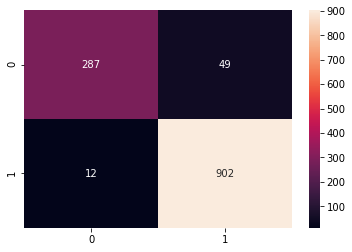

In [27]:
calc_scores("Simple RNN1",model_rnn1)

> One can see that the first base RNN model does a pretty good job in predicting the positive reviews with just *12 positive reviews wrongly predicted as negative*.    
> However it predicts as many as *49 negative reviews wrongly as positive*.

Let's see if the results improve with a LSTM Model

### Model 2 : LSTM
Second Model would be a LSTM with 200 Hidden Layers. Vocabulary size would be the default words stored in the Tokenizer object of Keras.     
Embedding size = 50

In [28]:
model_lstm1 = Sequential()
embedding_size = 50
model_lstm1.add(Embedding(vocab_size,embedding_size, input_length=maxlen)) #This layer takes each integer in the sequence and embeds it in a 50-dimensional vector
model_lstm1.add(LSTM(200))

model_lstm1.add(Dense(1, activation='sigmoid'))

In [29]:
model_lstm1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           1149900   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               200800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,350,901
Trainable params: 1,350,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_lstm1.compile(loss='binary_crossentropy',
                 optimizer=rmsprop,
                 metrics=['accuracy'])

In [31]:
model_lstm1.fit(x_train,y_train,
              batch_size = batch_size,
              epochs=10,
              validation_data = (x_test, y_test)
             )

Epoch 1/10
118/118 [==============================] - 16s 137ms/step - loss: 0.5967 - accuracy: 0.7261 - val_loss: 0.5764 - val_accuracy: 0.7312
Epoch 2/10
118/118 [==============================] - 18s 155ms/step - loss: 0.5753 - accuracy: 0.7315 - val_loss: 0.5590 - val_accuracy: 0.7312
Epoch 3/10
118/118 [==============================] - 19s 158ms/step - loss: 0.5643 - accuracy: 0.7315 - val_loss: 0.5733 - val_accuracy: 0.7312
Epoch 4/10
118/118 [==============================] - 19s 157ms/step - loss: 0.2864 - accuracy: 0.8813 - val_loss: 0.2374 - val_accuracy: 0.9192
Epoch 5/10
118/118 [==============================] - 18s 156ms/step - loss: 0.1497 - accuracy: 0.9539 - val_loss: 0.2032 - val_accuracy: 0.9424
Epoch 6/10
118/118 [==============================] - 18s 154ms/step - loss: 0.1079 - accuracy: 0.9661 - val_loss: 0.1728 - val_accuracy: 0.9528
Epoch 7/10
118/118 [==============================] - 19s 157ms/step - loss: 0.0810 - accuracy: 0.9760 - val_loss: 0.1713 - val_ac

One sees that the LSTM model has a __validation accuracy = 0.962__ and a __training accuracy = 0.990__. 

LSTM200 :

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       336
           1       0.96      0.99      0.97       914

    accuracy                           0.96      1250
   macro avg       0.97      0.94      0.95      1250
weighted avg       0.96      0.96      0.96      1250

Precision : 0.963
Recall : 0.962
ROC-AUC score : 0.990
Accuracy : 0.962


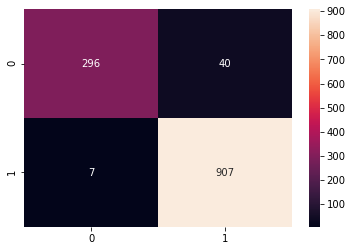

In [32]:
calc_scores("LSTM200",model_lstm1)

> One can see that the first LSTM model does a better job than simple RNN in predicting the positive reviews with just *7 positive reviews wrongly predicted as negative*.    
> It also predicts better than RNN with lesser *40 negative reviews wrongly as positive*.

In [33]:
scores_.sort_values(by='Precision', ascending=False)

,Model,Precision,Recall,ROC-AUC score,Accuracy
1,LSTM200,0.9629,0.9624,0.9895,0.9624
0,Simple RNN1,0.9515,0.9512,0.9783,0.9512


So one sees that the LSTM model does a better job than RNN in predicting the sentiments with a __higher roc-auc = 0.98 and a higher precision score = 0.96__.